# Exp12: Analyzing the augmented EGP
The goal of this experiment is to quantify the diversity of the generated dataset. First of all, the positive examples should not contain duplicates or very similar sentences. The negative examples should contain a wide range of sentences that are comparable to the language in the wild.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Read data

In [2]:
egp = pd.read_json("../dat/egpaugmented_54x100.json")

Get the sentences for one construction and count the number

In [8]:
sentences = egp.iloc[13]['augmented_examples']
len(sentences)

518

Count unique sentences

In [9]:
len(set(sentences))

502

Plot the number of repetitions of sentences as a histogram

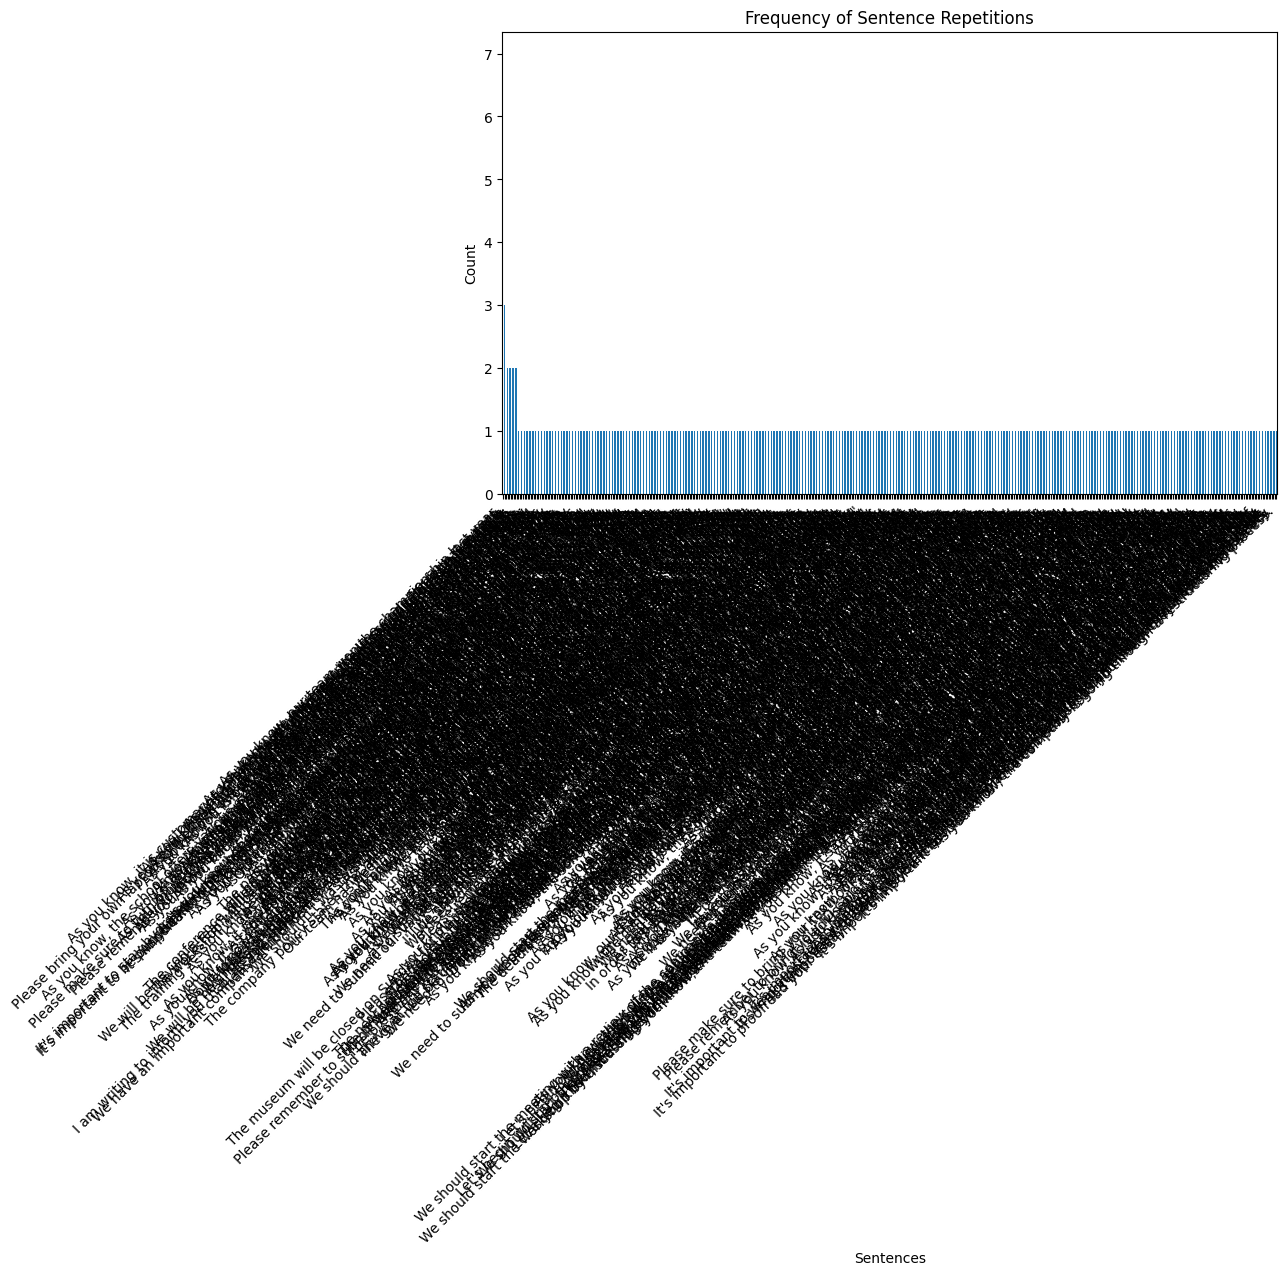

In [10]:
sentence_counts = pd.Series(sentences).value_counts()

plt.figure(figsize=(10, 6))
sentence_counts[sentence_counts>0].plot(kind='bar')
plt.title('Frequency of Sentence Repetitions')
plt.xlabel('Sentences')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

The histogram looks like expected, some sentences are repeated very often, others just once. Let's create summary statistics over all constructions for both positive and negative examples.

In [7]:
unique_ratio = egp.loc[egp['augmented_examples'].apply(lambda x: len(x)>0), 'augmented_examples'].apply(lambda sents: len(set(sents))/len(sents))
unique_ratio.mean()

0.9278577984993079

This looks okay! How is it for the negative examples?

In [7]:
egp.loc[egp['augmented_negative_examples'].apply(lambda x: len(x)>0), 'augmented_negative_examples'].apply(lambda sents: len(set(sents))/len(sents)).mean()

0.9416249753990888

Any outlier in the positive example uniqueness?

In [8]:
five_smallest = unique_ratio.nsmallest(5)
five_smallest

110    0.478
187    0.570
851    0.732
440    0.768
850    0.804
Name: augmented_examples, dtype: float64

Which are these? Easy ones?

In [9]:
egp.loc[five_smallest.index].Level

110    A1
187    A2
851    A1
440    A1
850    A1
Name: Level, dtype: object

Yes, they are all from beginner levels where it might be harder to come up with diverse examples.

## Sentence Embedding Similarities
Let's check sentences similarities against a corpus.

In [10]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [11]:
embeddings_model = SentenceTransformer('llmrails/ember-v1')

In [13]:
embeddings = embeddings_model.encode(sentences)
embeddings.shape

(500, 1024)

Let's calculate the average cosine similarity between embeddings.

In [14]:
total_similarity = 0
num_comparisons = 0
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        similarity = util.cos_sim(embeddings[i], embeddings[j])
        total_similarity += similarity.item()
        num_comparisons += 1

average_similarity = total_similarity / num_comparisons
print("Average Cosine Similarity:", average_similarity)

Average Cosine Similarity: 0.5349362740583553


More interestingly is this actually for negative examples. Let's make it a function and apply it to all negative examples.

In [15]:
def avg_cos_similarity(sentences):
    embeddings = embeddings_model.encode(sentences)
    total_similarity = 0
    num_comparisons = 0
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            similarity = util.cos_sim(embeddings[i], embeddings[j])
            total_similarity += similarity.item()
            num_comparisons += 1
    
    average_similarity = total_similarity / num_comparisons
    return average_similarity

Calculate it for all constructions with their positive examples.

In [24]:
pos_similarities = egp['augmented_examples'].apply(avg_cos_similarity)

In [29]:
print(f'mean: {pos_similarities.mean()}, std: {pos_similarities.std()}')

mean: 0.46183233545044233, std: 0.0522032492245023


Calculate it for all constructions with their negative examples.

In [25]:
neg_similarities = egp['augmented_negative_examples'].apply(avg_cos_similarity)

In [30]:
print(f'mean: {neg_similarities.mean()}, std: {neg_similarities.std()}')

mean: 0.4508003628742109, std: 0.0449430542307893


We need a comparison value from a corpus.

In [43]:
import nltk
nltk.download('brown')
nltk.download('punkt')
from nltk.corpus import brown
import random
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import config
random.seed(config.SEED)
import numpy as np

[nltk_data] Downloading package brown to
[nltk_data]     /home/cpsc488_dg963/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cpsc488_dg963/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
all_sentences = [' '.join(words) for words in brown.sents()]
sampled_sentences = random.sample(all_sentences, 500)

In [21]:
sampled_sentences[1:10]

['We were in business ! !',
 'The taunt was lost on Roberts .',
 "Don't urge your builder to give you a little extra cooling capacity just to be sure you have enough .",
 'Such payments shall be made to small domestic producers of lead as long as the market price for common lead at New York , New York , as determined by the Secretary , is below 14-1/2 cents per pound , and such payments shall be 75 per centum of the difference between 14-1/2 cents per pound and the average market price for the month in which the sale occurred as determined by the Secretary .',
 "`` Heaven forbid '' ! !",
 'F. H. Walker , superintendent ; ;',
 'Accounting procedures can be varied to provide a rationale for almost any price .',
 "There also came a brief contretemps with the sound mixers who made the mistake of being overheard during a quiet moment near the conclusion of `` Do It Again '' , and she made the tart observation that `` I never saw so much moving about in an audience '' .",
 'The bomb plunged 

In [46]:
baseline_similarities = np.array([avg_cos_similarity(random.sample(all_sentences, 500)) for _ in range(0, 10)])

In [47]:
print(f'mean: {baseline_similarities.mean()}, std: {baseline_similarities.std()}')

mean: 0.33383279892951545, std: 0.002146854882480211


Let's finally see if a random sampling may improve the diversity of the negative set.

In [38]:
def get_rand_sentences(row):
    num_sents = len(row['augmented_negative_examples'])
    num_rands = int(num_sents * 0.75)
    num_augs = num_sents - num_rands
    
    neg_examples = [example for sublist in egp.loc[egp['#'] != row['#'], 'augmented_examples'].to_list() for example in sublist]
    random.shuffle(neg_examples)
    sentences = neg_examples[:num_rands]
    
    aug_neg_examples = row['augmented_negative_examples']
    random.shuffle(aug_neg_examples)
    sentences += aug_neg_examples[:num_augs]
    return sentences

neg_rand_similarities = egp.apply(lambda row: avg_cos_similarity(get_rand_sentences(row)), axis=1)

In [39]:
print(f'mean: {neg_rand_similarities.mean()}, std: {neg_rand_similarities.std()}')

mean: 0.36908893660485154, std: 0.007333329783821504


Create a latex table to report findings

In [55]:
def format_row(name, data):
    return f"{name} & {data.mean():.3f} & {data.std():.3f} \\\\"

# Now, create the LaTeX table
latex_table = """
\\begin{tabular}{lll}
\\toprule
Corpus & Mean Cosine Similarity & Std. Dev. \\\\ \\midrule
%s
%s
%s
%s
\\bottomrule
\\end{tabular}
""" % (
    format_row("Brown", baseline_similarities),
    format_row("Positive", pos_similarities),
    format_row("Negative", neg_similarities),
    format_row("Negative with random other positives", neg_rand_similarities)
)

# Print the LaTeX table
print(latex_table)



\begin{tabular}{lll}
\toprule
Corpus & Mean Cosine Similarity & Std. Dev. \\ \midrule
Brown & 0.334 & 0.002 \\
Positive & 0.462 & 0.052 \\
Negative & 0.451 & 0.045 \\
Negative with random other positives & 0.369 & 0.007 \\
\bottomrule
\end{tabular}



# Count examples

In [19]:
import pandas as pd

# Define a list of file paths for different CEFR levels
cef_levels = ['../dat/egp_A1.json', '../dat/egp_A2.json', '../dat/egp_B1.json', '../dat/egp_B2.json', '../dat/egp_C1.json', '../dat/egp_C2.json']
threshold = 500

# Count rows based on the 'level' column and print
df = pd.read_json(cef_levels[0])
level_counts = df['Level'].value_counts()

for i, file_path in enumerate(cef_levels):
    df = pd.read_json(file_path)

    count_column1 = (df['augmented_examples'].apply(lambda x: len(set(x))) >= threshold).sum()
    count_column2 = (df['augmented_negative_examples'].apply(lambda x: len(set(x))) >= threshold/2).sum()

    print(f"CEFR Level {file_path}")
    total_level = level_counts[file_path[11:13]]
    print(f"Number of constructs with at least {threshold*1} positive examples: {count_column1}/{total_level}")
    print(f"Number of constructs with at least {int(threshold*0.5)} negative examples: {count_column2}/{total_level}")
    print("=" * 30)

CEFR Level ../dat/egp_A1.json
Number of constructs with at least 500 positive examples: 109/109
Number of constructs with at least 250 negative examples: 109/109
CEFR Level ../dat/egp_A2.json
Number of constructs with at least 500 positive examples: 291/291
Number of constructs with at least 250 negative examples: 291/291
CEFR Level ../dat/egp_B1.json
Number of constructs with at least 500 positive examples: 338/338
Number of constructs with at least 250 negative examples: 338/338
CEFR Level ../dat/egp_B2.json
Number of constructs with at least 500 positive examples: 243/243
Number of constructs with at least 250 negative examples: 243/243
CEFR Level ../dat/egp_C1.json
Number of constructs with at least 500 positive examples: 129/129
Number of constructs with at least 250 negative examples: 129/129
CEFR Level ../dat/egp_C2.json
Number of constructs with at least 500 positive examples: 112/112
Number of constructs with at least 250 negative examples: 112/112


In [20]:
# Define a list of file paths for different CEFR levels
cef_levels = ['../dat/egp_A1.json', '../dat/egp_A2.json', '../dat/egp_B1.json', '../dat/egp_B2.json', '../dat/egp_C1.json', '../dat/egp_C2.json']

for i, file_path in enumerate(cef_levels):
    df = pd.read_json(file_path)
    # in each row, look for augmented examples that are duplicates and only keep one of them
    df['augmented_examples_unique'] = df['augmented_examples'].apply(lambda x: list(set(x)))
    # count the differences of examples in the original and unique columns
    df['augmented_examples_unique_count'] = df['augmented_examples'].apply(len) - df['augmented_examples_unique'].apply(len)
    # print df['augmented_examples_unique_count'] for all rows where it is non-zero
    non_zero_counts = df.loc[df['augmented_examples_unique_count'] != 0, 'augmented_examples_unique_count']
    print(non_zero_counts.mean())


156.87037037037038
132.94076655052265
42.70716510903427
21.25225225225225
11.76530612244898
21.630434782608695
